In [1]:
import numpy as np
# read /data/csv/dependencies.csv

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from IPython.display import display
import os
from pathlib import Path

df = pd.read_csv("data/csv/dependencies.csv")

# df = df.head(1000)

G = nx.from_pandas_edgelist(
    df, source="dependency", target="package", create_using=nx.DiGraph()
)

print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())
print(
    "Number of weakly connected components:", nx.number_weakly_connected_components(G)
)
print(
    "Number of strongly connected components:",
    nx.number_strongly_connected_components(G),
)
print("Is directed:", nx.is_directed(G))

display(df)

Number of nodes: 4755
Number of edges: 13092
Number of weakly connected components: 33
Number of strongly connected components: 4755
Is directed: True


,package,dependency
0,coursier,openjdk
1,smpeg,sdl12-compat
2,fnt,chafa
3,fnt,lcdf-typetools
4,fnt,xz
...,...,...
13100,scalapack,openblas
13101,pwntools,certifi
13102,pwntools,cryptography
13103,pwntools,python@3.12


In [2]:
# Draw all weakly connected components
components = list(nx.weakly_connected_components(G))

plt.figure(figsize=(12, len(components) * 4))

<Figure size 1200x13200 with 0 Axes>

<Figure size 1200x13200 with 0 Axes>

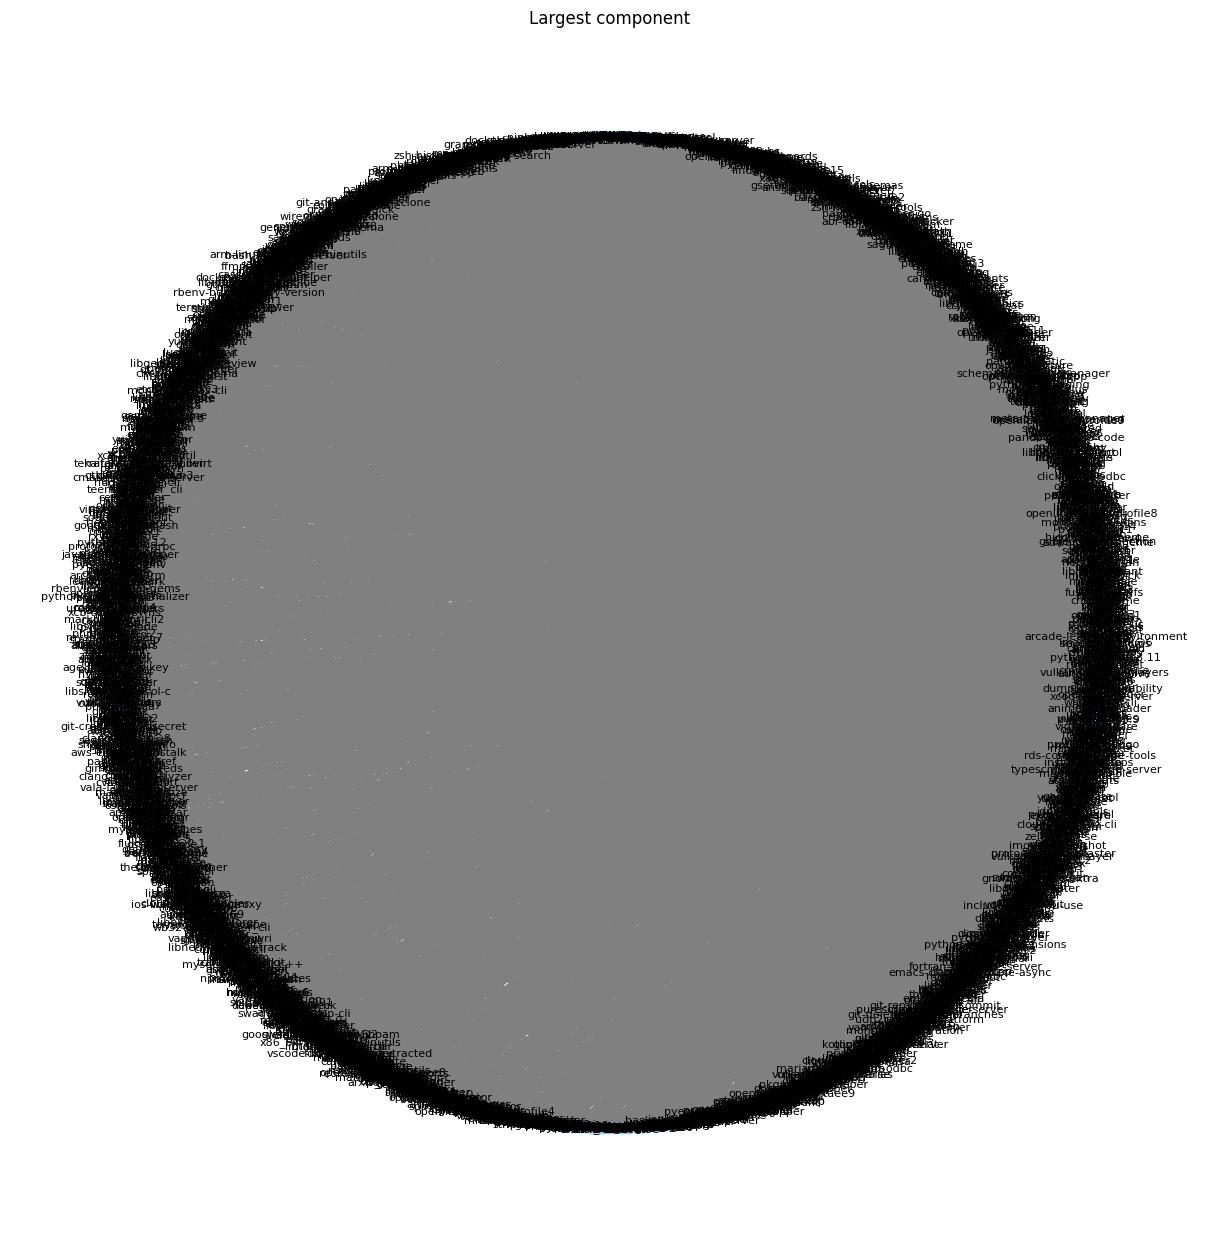

In [3]:
from networkx.drawing.nx_agraph import graphviz_layout

largest_component = max(components, key=len)

# Create a subgraph of the largest component
H = G.subgraph(largest_component)


# circular layout
pos = nx.circular_layout(H)

plt.figure(figsize=(12, 12))
nx.draw(
    H,
    pos,
    with_labels=True,
    node_size=50,
    node_color="skyblue",
    edge_color="gray",
    font_size=8,
)
plt.title("Largest component")
plt.axis("equal")
plt.show()

In [4]:
# Load package stats
stats = pd.read_csv(
    "data/csv/package_stats_with_contributors.csv",
    dtype={
        "install": "Int64",
        "install-on-request": "Int64",
        "contributors_count": "Int64",
    },
)
stats.loc[:, "repo_url"] = stats.loc[:, "repo_url"].fillna("")
stats.sort_values("install", ascending=False).head()

,Unnamed: 0,package,repo_url,install,install-on-request,contributors_count
3366,3390,openssl@3,,4237387,638832,<NA>
6589,6613,ca-certificates,,3328460,132784,<NA>
847,847,xz,,3074695,552466,<NA>
572,572,python@3.11,,2931813,1659811,<NA>
4654,4678,glib,,2605589,749141,<NA>


In [5]:
# Associate package stats with each node.

nodes_to_remove = []  # We can't modify the graph during iteration
for node in G.nodes:
    if node not in stats["package"].values:
        print(f"{node} not found in stats")
        nodes_to_remove.append(node)
        continue
    stats_row = stats[stats["package"] == node].iloc[0]
    G.nodes[node]["install"] = stats_row["install"]
    G.nodes[node]["install_on_request"] = stats_row["install-on-request"]
    if not pd.isnull(stats_row["contributors_count"]):
        G.nodes[node]["contributors_count"] = stats_row["contributors_count"]

print(f"Removing {len(nodes_to_remove)} nodes")
G.remove_nodes_from(nodes_to_remove)

wiiuse not found in stats
python not found in stats
cryptominisat not found in stats
pppd not found in stats
openssl not found in stats
fgbio not found in stats
libraqm not found in stats
wal2json not found in stats
thrift@0.9 not found in stats
liboauth not found in stats
gtksourceview3 not found in stats
hexer not found in stats
cvs-fast-export not found in stats
bit not found in stats
dtrx not found in stats
resty not found in stats
zboy not found in stats
libtar not found in stats
cf2tf not found in stats
ibex not found in stats
gypsy not found in stats
pygit2 not found in stats
Removing 22 nodes


In [6]:
def find_dependents_to_infect(package, popularity_metric="contributors_count"):
    """Finds all direct and indirect dependents of this package, sorting by the given popularity metric.

    We assume here that the package with the smallest metric (by default number of contributors)  lacks maintainers, and is therefore vulnerable to an XZ-style attack.
    """

    dependents = set()
    node = G.nodes[package]
    if popularity_metric in node:
        dependents.add((package, node[popularity_metric]))

    for dependent in G.predecessors(package):
        dependents.update(find_dependents_to_infect(dependent, popularity_metric))

    return sorted(dependents, key=lambda x: x[1])

In [7]:
find_dependents_to_infect("ruby")

[('zlib', 45), ('ruby', 778)]

In [8]:
find_dependents_to_infect("ruby", "install_on_request")

[('gperf', 2760),
 ('libxcrypt', 3961),
 ('libffi', 89561),
 ('ca-certificates', 132784),
 ('libyaml', 181738),
 ('zlib', 196695),
 ('ruby', 320779),
 ('openssl@3', 638832)]

## Number of dependencies histogram


Top 10 packages by dependency count


,Package,Number of Dependencies
2559,rtabmap,305
4156,dynare,282
3706,octave,279
3588,siril,277
4022,synfig,277
4044,visp,276
4002,mlt,264
3681,caffe,262
3207,mxnet,258
2560,opencv,257


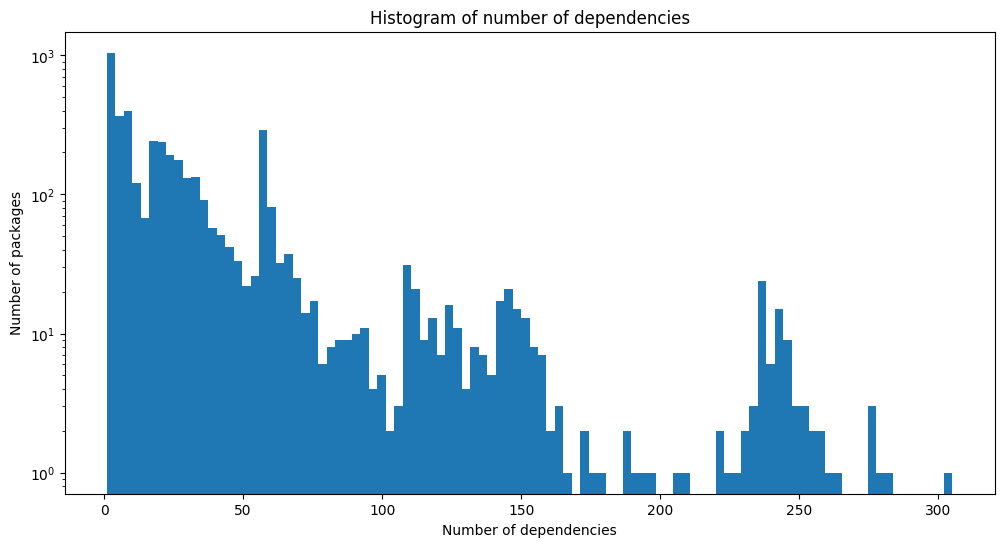

In [10]:
data_dir = Path("data")


def count_dependencies_reaching_package(graph, package_node):
    dependencies = set(nx.ancestors(graph, package_node))
    return len(dependencies)


dependency_counts = {
    node: count_dependencies_reaching_package(G, node)
    for node in G.nodes
    if G.in_degree(node) > 0
}

dependency_counts_df = pd.DataFrame(
    list(dependency_counts.items()), columns=["Package", "Number of Dependencies"]
)


print("Top 10 packages by dependency count")
dependency_counts_df = dependency_counts_df.sort_values(
    "Number of Dependencies", ascending=False
)

display(dependency_counts_df.head(10))


# histogram of dependency count
plt.figure(figsize=(12, 6))
plt.hist(dependency_counts.values(), bins=100, log=True)
plt.xlabel("Number of dependencies")
plt.ylabel("Number of packages")
plt.title("Histogram of number of dependencies")
plt.show()

# Hierarchical dependency graph for the qt package


In [25]:
df_qt = pd.read_csv("data/csv/qt.csv")

package_stats = pd.read_csv("data/csv/package_stats_with_contributors.csv")

display(package_stats.head(10))

G_qt = nx.from_pandas_edgelist(
    df_qt, target="package", source="dependency", create_using=nx.DiGraph()
)

pos_hierarchic = nx.nx_agraph.graphviz_layout(G_qt, prog="dot")

nx.draw(
    G_qt,
    pos_hierarchic,
    with_labels=False,
    node_size=50,
    node_color="skyblue",
    edge_color="gray",
    font_size=8,
)
plt.title("qt package dependency graph")

plt.tight_layout()
plt.show()

,Unnamed: 0,package,repo_url,install,install-on-request,contributors_count
0,0,libkate,NaN,1937.0,99.0,NaN
1,1,bandwhich,NaN,3498.0,3497.0,NaN
2,2,git-revise,https://github.com/mystor/git-revise.git,325.0,325.0,19.0
3,3,mkvalidator,NaN,93.0,93.0,NaN
4,4,dps8m,https://gitlab.com/dps8m/dps8m.git,73.0,73.0,NaN
5,5,aurora,NaN,274.0,274.0,NaN
6,6,proj,https://github.com/OSGeo/proj.git,81729.0,33209.0,160.0
7,7,json-table,https://github.com/micha/json-table.git,67.0,67.0,3.0
8,8,jpeg-archive,NaN,84.0,84.0,NaN
9,9,howdoi,NaN,4556.0,4556.0,NaN


ImportError: requires pygraphviz http://pygraphviz.github.io/

# Prepare Edge Weights (infection probabilities)

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 1.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 4.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 2.000e+00, 0.000e+00, 3.000e+00, 3.000e+00, 1.000e+00,
        2.000e+00, 0.000e+00, 2.000e+0

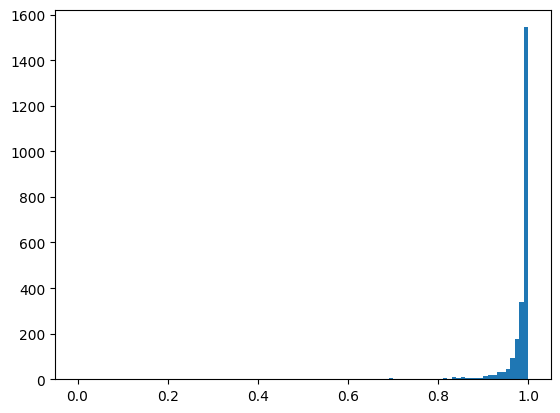

In [20]:
a, b = 0.0001, 0.95
contributors = package_stats['contributors_count']
normalized_contributors = -(contributors-contributors.min())/(contributors.max()-contributors.min()) + 1
normalized_and_scaled_contributors = normalized_contributors * (b - a) + a
normalized_and_scaled_contributors.head()
plt.hist(normalized_contributors, bins=100)

# Infection impact analysis


In [21]:
from ndlib.models.epidemics import IndependentCascadesModel
from ndlib.models import ModelConfig

SUSC, INF, REM = 0, 1, 2

def get_infection_probability(edge, min_infection_probability):
    contributors_indices = package_stats.index[package_stats['package'] == edge[1]]
    if len(contributors_indices) > 0:
        # Assumes only one item, will throw an exception if there's more (there shouldn't be)
        infection_probability = normalized_and_scaled_contributors.loc[contributors_indices.item()]
    else:
        infection_probability = min_infection_probability
    return infection_probability


def estimate_infection_fallout(first_package, min_infection_probability):
    model = IndependentCascadesModel(G)
    config = ModelConfig.Configuration()
    config.add_model_initial_configuration("Infected", [first_package])

    for edge in G.edges:
        infection_probability = get_infection_probability(edge, min_infection_probability)
        infection_probability = infection_probability if infection_probability != np.nan else 0.47495
        config.add_edge_configuration("threshold", edge, infection_probability)

    model.set_initial_status(config)
    iterations = model.iteration_bunch(20)

    infected_packages, infected_users = 0, 0
    for iteration in iterations:
        status = iteration["status"]
        for node, node_status in status.items():
            if node_status == INF:
                infected_packages += 1
                # We can't sum installs directly, as installing a package also installs its dependencies, so some users might be counted multiple times.
                # Instead, we rely on the fact that a package is either installed or request or as a dependency
                # In the latter case, it will be counted when we analyze its dependent packages.
                infected_users += G.nodes[node]["install_on_request"]
        trends = model.build_trends(iterations)
    return model, trends, infected_packages, infected_users

Estimated number of infected packages: 292
Estimated number of infected users: 12817618


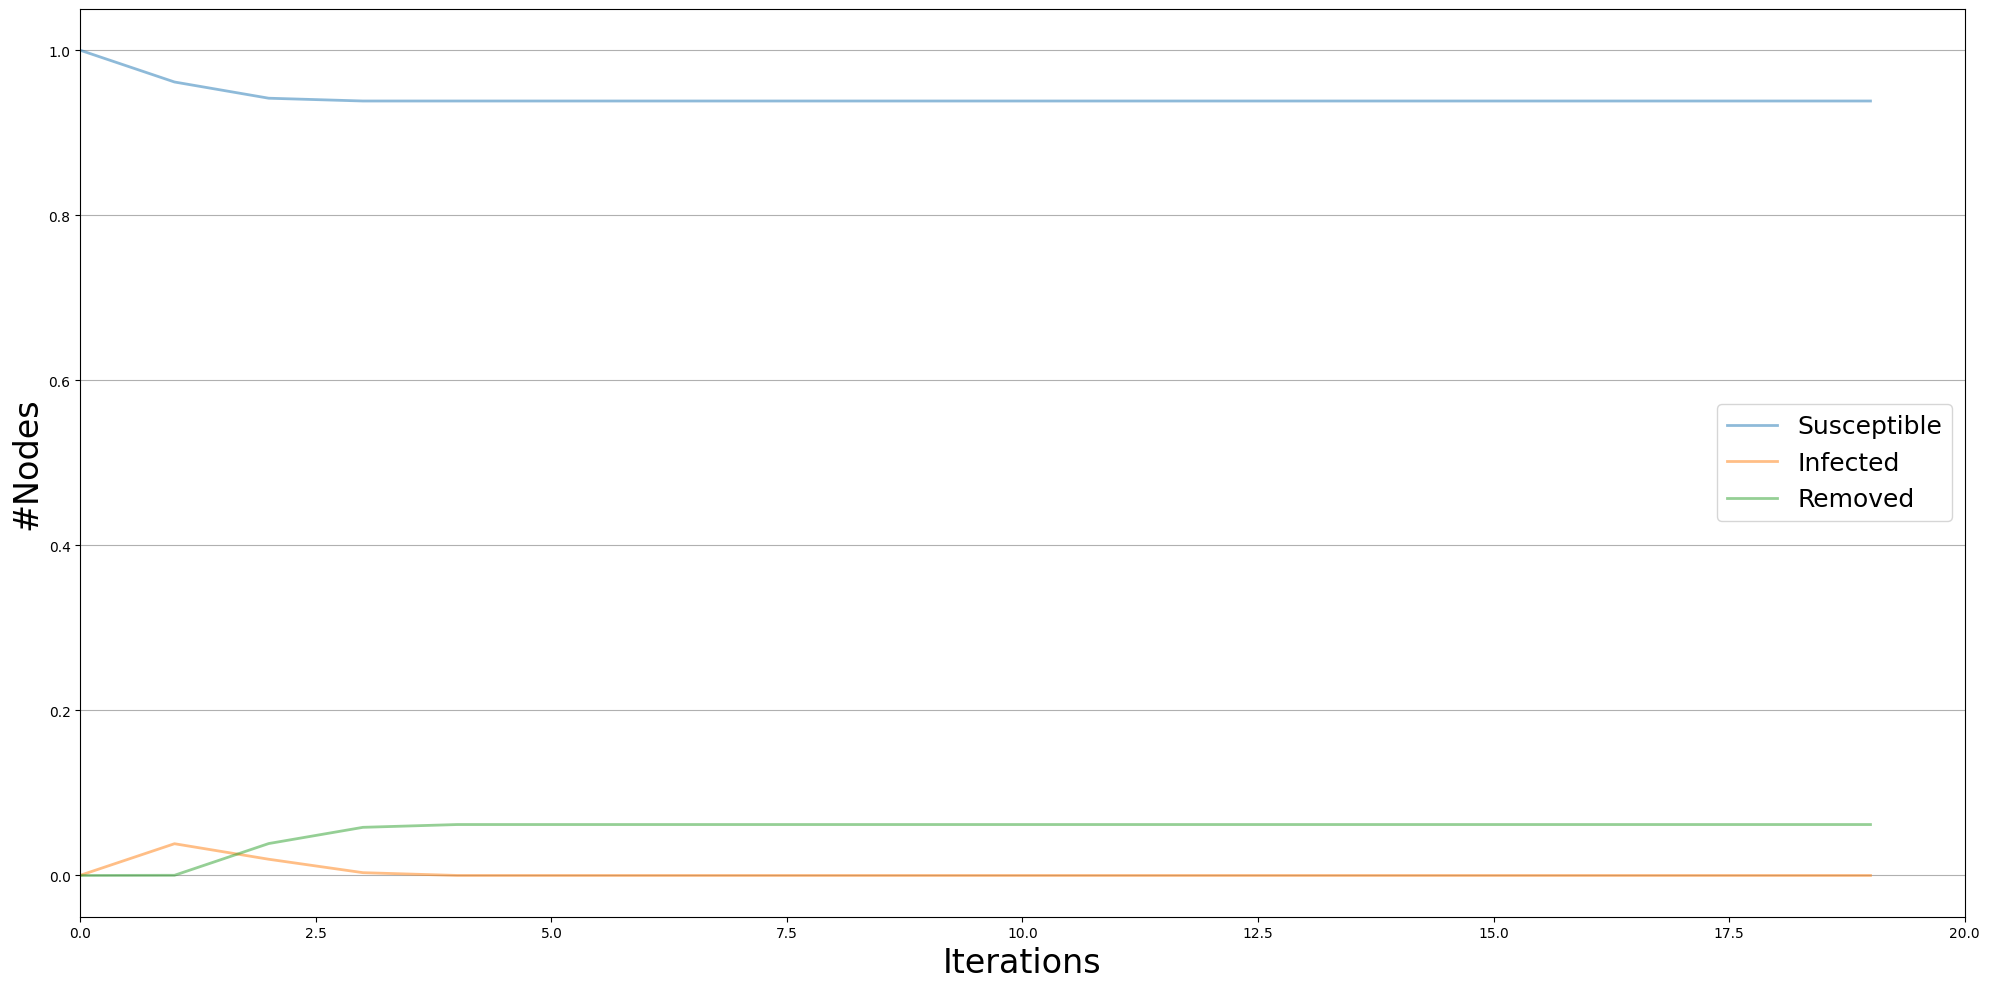

In [24]:
from ndlib.viz.mpl.DiffusionTrend import DiffusionTrend

model, trends, infected_packages, infected_users = estimate_infection_fallout("openssl@3", a)
print(f"Estimated number of infected packages: {infected_packages}")
print(f"Estimated number of infected users: {infected_users}")
DiffusionTrend(model, trends).plot()